# 로이터 뉴스 분류하기 - LSTM

### 데이터 탐색

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
import warnings
warnings.filterwarnings('ignore')

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


In [3]:
# 데이터 갯수
len(X_train), len(X_test)

(8982, 2246)

In [4]:
# 카테고리 갯수
max(y_train) + 1

46

In [5]:
# 첫번째 뉴스: reuter 데이터는 토큰화와 정수 인코딩이 끝난 상태
# 단어의 빈도수에 따라 정수를 부여함: 1이라는 숫자는 등장빈도가 1등
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
type(reuters.get_word_index()), reuters.get_word_index()['the']

565248/550378 [==============================] - 0s 0us/step


(dict, 1)

In [7]:
print(reuters.get_word_index().keys())
print(reuters.get_word_index().values())
print(reuters.get_word_index().items())

dict_keys(['mdbl', 'fawc', 'degussa', 'woods', 'hanging', 'localized', 'sation', 'chanthaburi', 'refunding', 'hermann', 'passsengers', 'stipulate', 'heublein', 'screaming', 'tcby', 'four', 'grains', 'broiler', 'wooden', 'wednesday', 'highveld', 'duffour', '0053', 'elections', '270', '271', '272', '273', '274', 'rudman', '276', '277', '278', '279', 'dormancy', 'errors', 'deferred', 'sptnd', 'cooking', 'stratabit', 'designing', 'metalurgicos', 'databank', '300er', 'shocks', 'nawg', 'tnta', 'perforations', 'affiliates', '27p', 'ching', 'china', 'wagyu', 'affiliated', 'chino', 'chinh', 'slickline', 'doldrums', 'kids', 'climbed', 'controversy', 'kidd', 'spotty', 'rebel', 'millimetres', 'golden', 'projection', 'stern', "hudson's", 'dna', 'dnc', 'hodler', 'lme', 'insolvancy', 'music', 'therefore', 'dns', 'distortions', 'thassos', 'populations', 'meteorologist', 'loss', 'exco', 'adventist', 'murchison', 'locked', 'kampala', 'arndt', 'nakasone', 'steinweg', "india's", 'wang', 'wane', 'unjust', 

In [8]:
index_word = {}
for key, value in reuters.get_word_index().items():
    index_word[value] = key
len(index_word)

30979

In [9]:
# 첫번째 기사 복원
' '.join([index_word[index] for index in X_train[0]])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [10]:
# 뉴스 기사의 길이
print('뉴스 최대 길이: ', max(len(s) for s in X_train))

# X_train의 각 element에 적용하기 위해 map()을 사용
print('뉴스 평균 길이: ', sum(map(len, X_train)) / len(X_train))    

뉴스 최대 길이:  2376
뉴스 평균 길이:  145.5398574927633


In [11]:
# sum(map(len,x)) 설명
x = [[1,2,3],[4,5,6],[8,9]]
sum(map(len,x))

8

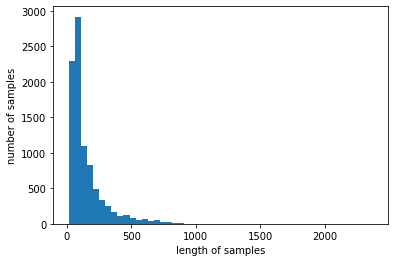

In [12]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

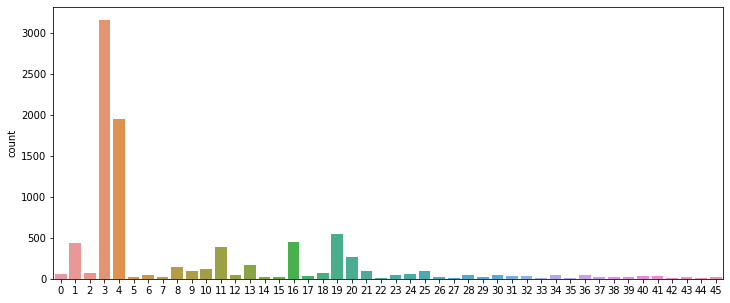

In [13]:
# y_train은 뉴스 기사들의 레이블들을 의미
# y_train[0]=3 --> 46개의 카테고리 중 3에 해당하는 카테고리
plt.figure(figsize=(12,5))
sns.countplot(y_train);

### LSTM으로 로이터 뉴스 분류
- 단어: 빈도수 기준 1,000 단어 (총 단어수: 30.979개)
- 문장길이: 100 단어까지 (최대 2,376)

In [14]:
# 프로그램 코드 안에서는 숫자가 아닌 변수를 사용하도록 한다.
num_words = 1000
max_len = 100

In [15]:
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

In [18]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

- 모델 정의/설정/학습

In [19]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

In [20]:
model = Sequential([ 
    Embedding(num_words, embedding_dim, input_length=max_len),
    LSTM(hidden_units),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          128000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 46)                5934      
                                                                 
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [22]:
model_path = 'best-reuters-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [23]:
hist = model.fit(
    X_train, Y_train, epochs=30, batch_size=128,
    validation_split=0.2, callbacks=[mc, es]
)

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 2.6760 - accuracy: 0.3354
Epoch 00001: val_loss improved from inf to 2.31994, saving model to best-reuters-lstm.h5
57/57 [==============================] - 13s 44ms/step - loss: 2.6760 - accuracy: 0.3354 - val_loss: 2.3199 - val_accuracy: 0.3450
Epoch 2/30
56/57 [============================>.] - ETA: 0s - loss: 2.0407 - accuracy: 0.4576
Epoch 00002: val_loss improved from 2.31994 to 1.87924, saving model to best-reuters-lstm.h5
57/57 [==============================] - 1s 23ms/step - loss: 2.0405 - accuracy: 0.4575 - val_loss: 1.8792 - val_accuracy: 0.4936
Epoch 3/30
55/57 [===========================>..] - ETA: 0s - loss: 1.8364 - accuracy: 0.5227
Epoch 00003: val_loss did not improve from 1.87924
57/57 [==============================] - 1s 24ms/step - loss: 1.8431 - accuracy: 0.5196 - val_loss: 2.0106 - val_accuracy: 0.4391
Epoch 4/30
57/57 [==============================] - ETA: 0s - loss: 1.9411 - accuracy: 0.4813


In [24]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 5ms/step - loss: 1.2933 - accuracy: 0.6910


[1.2932908535003662, 0.6910062432289124]

- Case 2) max_len = 300 

In [25]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=num_words, test_split=0.2)

In [26]:
max_len = 300
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 300), (2246, 300), (8982, 46), (2246, 46))

In [27]:
model2 = Sequential([ 
    Embedding(num_words, embedding_dim, input_length=max_len),
    LSTM(hidden_units),
    Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          128000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 46)                5934      
                                                                 
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


In [28]:
model2.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [29]:
model_path = 'best-reuters-lstm2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [30]:
hist2 = model2.fit(
    X_train, Y_train, epochs=50, batch_size=128,
    validation_split=0.2, callbacks=[mc, es]
)

Epoch 1/50
55/57 [===========================>..] - ETA: 0s - loss: 2.6856 - accuracy: 0.3445
Epoch 00001: val_loss improved from inf to 2.40922, saving model to best-reuters-lstm2.h5
57/57 [==============================] - 4s 37ms/step - loss: 2.6750 - accuracy: 0.3456 - val_loss: 2.4092 - val_accuracy: 0.3450
Epoch 2/50
56/57 [============================>.] - ETA: 0s - loss: 2.2923 - accuracy: 0.3982
Epoch 00002: val_loss improved from 2.40922 to 2.05685, saving model to best-reuters-lstm2.h5
57/57 [==============================] - 1s 26ms/step - loss: 2.2919 - accuracy: 0.3982 - val_loss: 2.0569 - val_accuracy: 0.4775
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 1.9607 - accuracy: 0.4989
Epoch 00003: val_loss improved from 2.05685 to 1.93824, saving model to best-reuters-lstm2.h5
57/57 [==============================] - 2s 27ms/step - loss: 1.9608 - accuracy: 0.4990 - val_loss: 1.9382 - val_accuracy: 0.4953
Epoch 4/50
57/57 [==============================] 

In [31]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 10ms/step - loss: 1.0996 - accuracy: 0.7449


[1.0995837450027466, 0.7448797821998596]